# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell below and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:20, 8.89MB/s]                              
SVHN Testing Set: 64.3MB [00:08, 7.63MB/s]                            


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

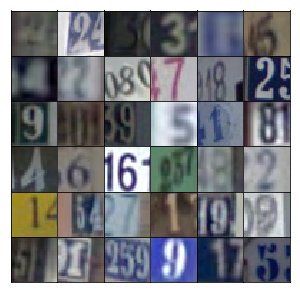

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def generator(noise, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        # As described above this does the projection and reshaping from 
        # the 100 input nodes to a 4 x 4 x 512 layer
        # As we only need to scale up to 32 x 32, we take a similar architecture as above, 
        # but half the sizes.
        project_and_reshape = tf.layers.dense(inputs=noise, units=4 * 4 * 512)
        project_and_reshape = tf.reshape(project_and_reshape, (-1, 4, 4, 512))
        project_and_reshape = tf.layers.batch_normalization(project_and_reshape, training=training)
        project_and_reshape = tf.maximum(alpha * project_and_reshape, project_and_reshape)
        
        # First transposed convolution now going to 256 x 8 x 8
        conv1 = tf.layers.conv2d_transpose(project_and_reshape, filters=256, kernel_size=5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=training)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        # Second transposed convolution now going to 128 x 16 x 16
        conv2 = tf.layers.conv2d_transpose(conv1, filters=128, kernel_size=5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=training)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        # Output layer, 32x32x3
        # The 32 x 32 resolution is defined by using a stride of 2 on the 16 x 16 previous conv2d layer
        # The number of color output channels (3) is defined by the output_dim parameter
        logits = tf.layers.conv2d_transpose(conv2, filters=output_dim, kernel_size=5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        conv1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, filters=128, kernel_size=5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, filters=256, kernel_size=5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        flatten = tf.reshape(conv3, (-1, 4*4*256))
        
        logits = tf.layers.dense(flatten, 1)
        
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [16]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 0.1313... Generator Loss: 3.0616
Epoch 1/25... Discriminator Loss: 0.0896... Generator Loss: 3.4738
Epoch 1/25... Discriminator Loss: 0.6616... Generator Loss: 1.4211
Epoch 1/25... Discriminator Loss: 0.5655... Generator Loss: 2.3691
Epoch 1/25... Discriminator Loss: 0.5170... Generator Loss: 2.5585
Epoch 1/25... Discriminator Loss: 0.5417... Generator Loss: 1.4519
Epoch 1/25... Discriminator Loss: 0.3623... Generator Loss: 2.6653
Epoch 1/25... Discriminator Loss: 0.5485... Generator Loss: 1.8813
Epoch 1/25... Discriminator Loss: 0.6437... Generator Loss: 1.7543
Epoch 1/25... Discriminator Loss: 0.9292... Generator Loss: 1.2541


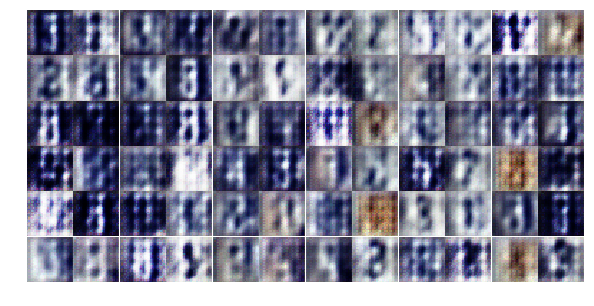

Epoch 1/25... Discriminator Loss: 0.5827... Generator Loss: 1.6865
Epoch 2/25... Discriminator Loss: 0.9187... Generator Loss: 1.1203
Epoch 2/25... Discriminator Loss: 0.9386... Generator Loss: 1.1629
Epoch 2/25... Discriminator Loss: 1.1341... Generator Loss: 0.8982
Epoch 2/25... Discriminator Loss: 1.0192... Generator Loss: 1.1634
Epoch 2/25... Discriminator Loss: 1.6141... Generator Loss: 0.3688
Epoch 2/25... Discriminator Loss: 1.0085... Generator Loss: 1.0815
Epoch 2/25... Discriminator Loss: 1.1454... Generator Loss: 1.2809
Epoch 2/25... Discriminator Loss: 0.9604... Generator Loss: 0.9334
Epoch 2/25... Discriminator Loss: 0.9711... Generator Loss: 1.0898


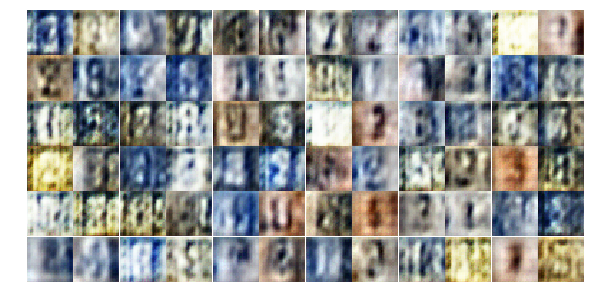

Epoch 2/25... Discriminator Loss: 1.0839... Generator Loss: 0.9042
Epoch 2/25... Discriminator Loss: 0.9932... Generator Loss: 1.1992
Epoch 3/25... Discriminator Loss: 1.1005... Generator Loss: 1.6522
Epoch 3/25... Discriminator Loss: 1.0655... Generator Loss: 0.9768
Epoch 3/25... Discriminator Loss: 0.7610... Generator Loss: 1.0271
Epoch 3/25... Discriminator Loss: 0.8205... Generator Loss: 1.0137
Epoch 3/25... Discriminator Loss: 0.8273... Generator Loss: 1.0044
Epoch 3/25... Discriminator Loss: 0.8274... Generator Loss: 1.3228
Epoch 3/25... Discriminator Loss: 1.2793... Generator Loss: 0.5408
Epoch 3/25... Discriminator Loss: 0.4911... Generator Loss: 1.5509


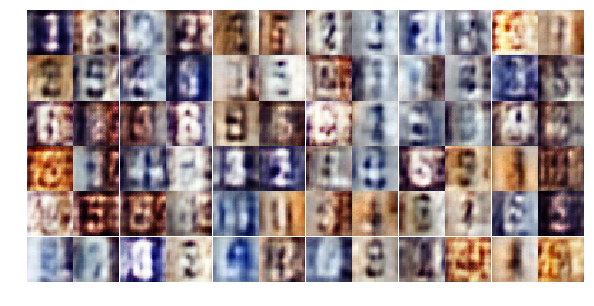

Epoch 3/25... Discriminator Loss: 0.5244... Generator Loss: 1.8918
Epoch 3/25... Discriminator Loss: 0.6116... Generator Loss: 1.1386
Epoch 3/25... Discriminator Loss: 0.4970... Generator Loss: 1.4667
Epoch 3/25... Discriminator Loss: 0.6376... Generator Loss: 1.1914
Epoch 4/25... Discriminator Loss: 0.4347... Generator Loss: 1.6134
Epoch 4/25... Discriminator Loss: 0.4457... Generator Loss: 1.6329
Epoch 4/25... Discriminator Loss: 0.9430... Generator Loss: 1.5720
Epoch 4/25... Discriminator Loss: 0.6092... Generator Loss: 1.9989
Epoch 4/25... Discriminator Loss: 0.5220... Generator Loss: 2.2877
Epoch 4/25... Discriminator Loss: 0.4420... Generator Loss: 2.2967


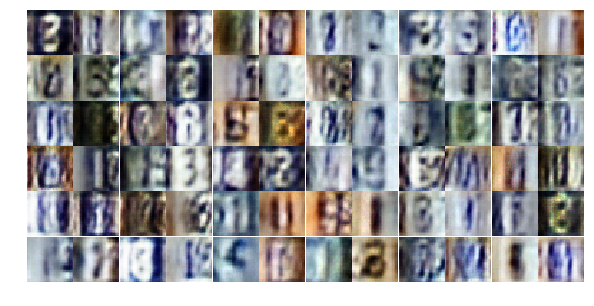

Epoch 4/25... Discriminator Loss: 0.3734... Generator Loss: 2.2758
Epoch 4/25... Discriminator Loss: 0.5732... Generator Loss: 1.4805
Epoch 4/25... Discriminator Loss: 0.4797... Generator Loss: 1.9406
Epoch 4/25... Discriminator Loss: 0.4235... Generator Loss: 1.6016
Epoch 4/25... Discriminator Loss: 0.4773... Generator Loss: 1.5070
Epoch 5/25... Discriminator Loss: 0.5483... Generator Loss: 1.7015
Epoch 5/25... Discriminator Loss: 0.2949... Generator Loss: 2.1658
Epoch 5/25... Discriminator Loss: 0.5198... Generator Loss: 1.6032
Epoch 5/25... Discriminator Loss: 0.9460... Generator Loss: 1.1736
Epoch 5/25... Discriminator Loss: 0.5476... Generator Loss: 1.3629


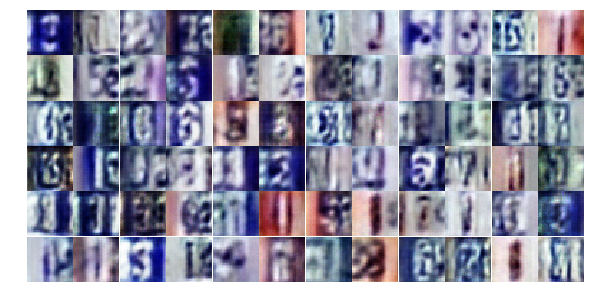

Epoch 5/25... Discriminator Loss: 0.7988... Generator Loss: 0.8217
Epoch 5/25... Discriminator Loss: 0.4512... Generator Loss: 1.5265
Epoch 5/25... Discriminator Loss: 0.5994... Generator Loss: 1.7420
Epoch 5/25... Discriminator Loss: 0.8412... Generator Loss: 0.7642
Epoch 5/25... Discriminator Loss: 1.3753... Generator Loss: 0.4357
Epoch 5/25... Discriminator Loss: 0.4900... Generator Loss: 1.5430
Epoch 5/25... Discriminator Loss: 0.5172... Generator Loss: 1.3390
Epoch 6/25... Discriminator Loss: 0.7475... Generator Loss: 1.0197
Epoch 6/25... Discriminator Loss: 0.8742... Generator Loss: 0.8113
Epoch 6/25... Discriminator Loss: 0.6589... Generator Loss: 1.7591


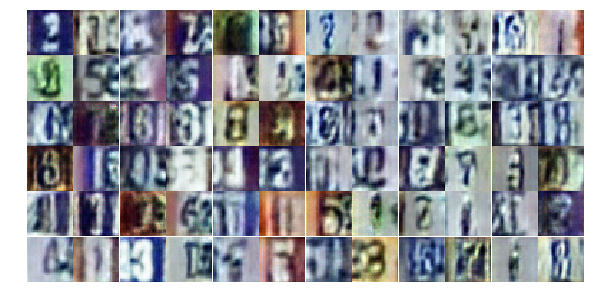

Epoch 6/25... Discriminator Loss: 0.3529... Generator Loss: 2.2351
Epoch 6/25... Discriminator Loss: 0.9108... Generator Loss: 0.7490
Epoch 6/25... Discriminator Loss: 0.5414... Generator Loss: 2.6000
Epoch 6/25... Discriminator Loss: 0.3707... Generator Loss: 1.7345
Epoch 6/25... Discriminator Loss: 1.3912... Generator Loss: 0.4068
Epoch 6/25... Discriminator Loss: 0.5442... Generator Loss: 1.2033
Epoch 6/25... Discriminator Loss: 0.6068... Generator Loss: 1.2334
Epoch 6/25... Discriminator Loss: 1.0921... Generator Loss: 0.6880
Epoch 7/25... Discriminator Loss: 0.6784... Generator Loss: 1.6225
Epoch 7/25... Discriminator Loss: 1.4250... Generator Loss: 0.3729


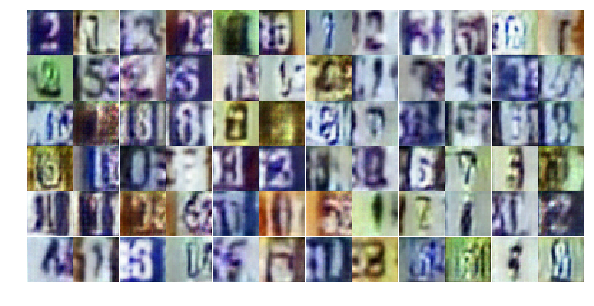

Epoch 7/25... Discriminator Loss: 0.6230... Generator Loss: 1.1063
Epoch 7/25... Discriminator Loss: 0.6512... Generator Loss: 1.0500
Epoch 7/25... Discriminator Loss: 0.4223... Generator Loss: 1.6706
Epoch 7/25... Discriminator Loss: 0.4933... Generator Loss: 1.9596
Epoch 7/25... Discriminator Loss: 0.6867... Generator Loss: 0.9814
Epoch 7/25... Discriminator Loss: 0.3928... Generator Loss: 2.3977
Epoch 7/25... Discriminator Loss: 2.5158... Generator Loss: 4.5493
Epoch 7/25... Discriminator Loss: 0.6995... Generator Loss: 1.0659
Epoch 7/25... Discriminator Loss: 0.5062... Generator Loss: 1.3301
Epoch 7/25... Discriminator Loss: 0.5028... Generator Loss: 1.3679


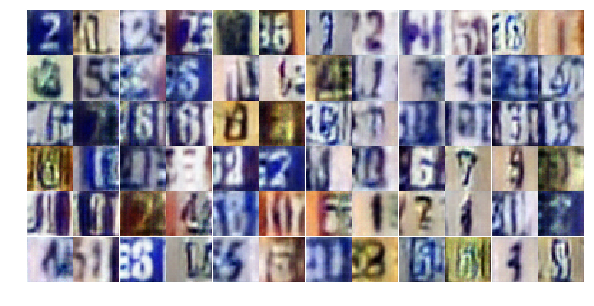

Epoch 8/25... Discriminator Loss: 0.6867... Generator Loss: 0.9631
Epoch 8/25... Discriminator Loss: 0.8836... Generator Loss: 1.4062
Epoch 8/25... Discriminator Loss: 0.7518... Generator Loss: 0.9662
Epoch 8/25... Discriminator Loss: 1.3026... Generator Loss: 0.4271
Epoch 8/25... Discriminator Loss: 0.4801... Generator Loss: 1.5874
Epoch 8/25... Discriminator Loss: 0.8736... Generator Loss: 0.8348
Epoch 8/25... Discriminator Loss: 0.6252... Generator Loss: 1.1967
Epoch 8/25... Discriminator Loss: 0.4603... Generator Loss: 1.6826
Epoch 8/25... Discriminator Loss: 0.7410... Generator Loss: 2.4148
Epoch 8/25... Discriminator Loss: 0.6348... Generator Loss: 2.1101


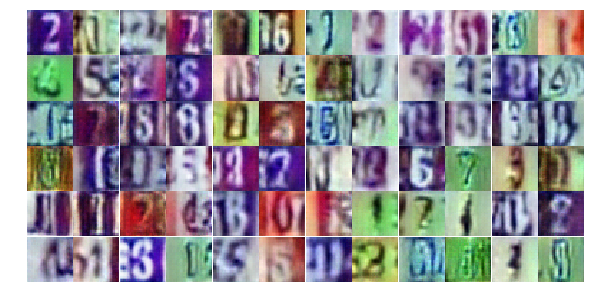

Epoch 8/25... Discriminator Loss: 0.4276... Generator Loss: 1.9384
Epoch 9/25... Discriminator Loss: 1.0529... Generator Loss: 0.5811
Epoch 9/25... Discriminator Loss: 1.0483... Generator Loss: 0.6132
Epoch 9/25... Discriminator Loss: 0.5166... Generator Loss: 1.4891
Epoch 9/25... Discriminator Loss: 0.5674... Generator Loss: 1.3359
Epoch 9/25... Discriminator Loss: 0.7906... Generator Loss: 0.8046
Epoch 9/25... Discriminator Loss: 0.4611... Generator Loss: 2.3548
Epoch 9/25... Discriminator Loss: 0.5487... Generator Loss: 1.1912
Epoch 9/25... Discriminator Loss: 0.7776... Generator Loss: 0.9479
Epoch 9/25... Discriminator Loss: 0.8993... Generator Loss: 0.7936


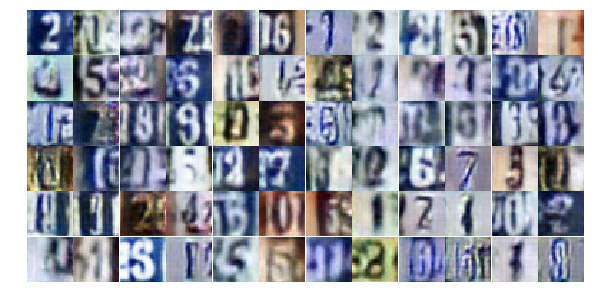

Epoch 9/25... Discriminator Loss: 0.4734... Generator Loss: 2.4088
Epoch 9/25... Discriminator Loss: 0.6860... Generator Loss: 2.4630
Epoch 9/25... Discriminator Loss: 0.6217... Generator Loss: 1.3700
Epoch 10/25... Discriminator Loss: 0.8998... Generator Loss: 0.6950
Epoch 10/25... Discriminator Loss: 0.5070... Generator Loss: 1.5261
Epoch 10/25... Discriminator Loss: 0.6886... Generator Loss: 1.0425
Epoch 10/25... Discriminator Loss: 0.5970... Generator Loss: 1.1775
Epoch 10/25... Discriminator Loss: 0.2799... Generator Loss: 3.0780
Epoch 10/25... Discriminator Loss: 1.3793... Generator Loss: 0.4259
Epoch 10/25... Discriminator Loss: 0.5966... Generator Loss: 1.0742


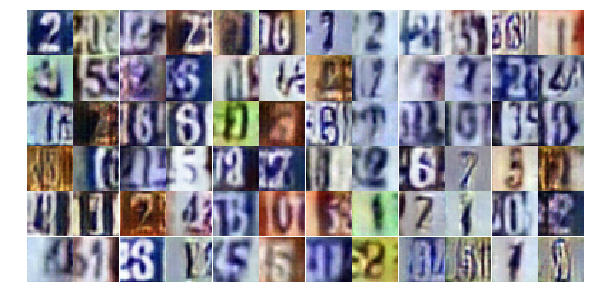

Epoch 10/25... Discriminator Loss: 0.7278... Generator Loss: 0.9246
Epoch 10/25... Discriminator Loss: 0.4223... Generator Loss: 1.8873
Epoch 10/25... Discriminator Loss: 0.6982... Generator Loss: 2.1741
Epoch 10/25... Discriminator Loss: 0.5901... Generator Loss: 1.1698
Epoch 11/25... Discriminator Loss: 0.9011... Generator Loss: 0.6844
Epoch 11/25... Discriminator Loss: 1.5033... Generator Loss: 0.4041
Epoch 11/25... Discriminator Loss: 0.7143... Generator Loss: 1.2462
Epoch 11/25... Discriminator Loss: 1.3980... Generator Loss: 0.4268
Epoch 11/25... Discriminator Loss: 0.3212... Generator Loss: 1.9130
Epoch 11/25... Discriminator Loss: 0.6243... Generator Loss: 1.0560


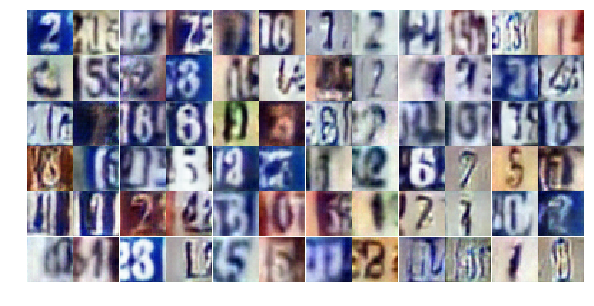

Epoch 11/25... Discriminator Loss: 0.4940... Generator Loss: 1.3037
Epoch 11/25... Discriminator Loss: 1.2620... Generator Loss: 0.4475
Epoch 11/25... Discriminator Loss: 0.9042... Generator Loss: 0.7205
Epoch 11/25... Discriminator Loss: 0.3901... Generator Loss: 1.5742
Epoch 11/25... Discriminator Loss: 1.8353... Generator Loss: 0.3282
Epoch 11/25... Discriminator Loss: 0.8622... Generator Loss: 0.8677
Epoch 12/25... Discriminator Loss: 0.5114... Generator Loss: 1.2105
Epoch 12/25... Discriminator Loss: 1.9044... Generator Loss: 0.2288
Epoch 12/25... Discriminator Loss: 0.5347... Generator Loss: 1.5944
Epoch 12/25... Discriminator Loss: 0.7425... Generator Loss: 0.9584


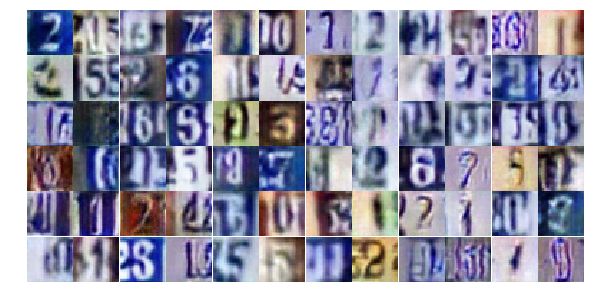

Epoch 12/25... Discriminator Loss: 0.4280... Generator Loss: 1.6898
Epoch 12/25... Discriminator Loss: 0.4684... Generator Loss: 1.6310
Epoch 12/25... Discriminator Loss: 0.3972... Generator Loss: 1.7890
Epoch 12/25... Discriminator Loss: 0.3340... Generator Loss: 1.9090
Epoch 12/25... Discriminator Loss: 0.8527... Generator Loss: 0.8217
Epoch 12/25... Discriminator Loss: 0.7318... Generator Loss: 2.5234
Epoch 12/25... Discriminator Loss: 1.5673... Generator Loss: 1.0705
Epoch 13/25... Discriminator Loss: 0.7472... Generator Loss: 0.9537
Epoch 13/25... Discriminator Loss: 0.5508... Generator Loss: 1.3334
Epoch 13/25... Discriminator Loss: 0.5998... Generator Loss: 1.0383


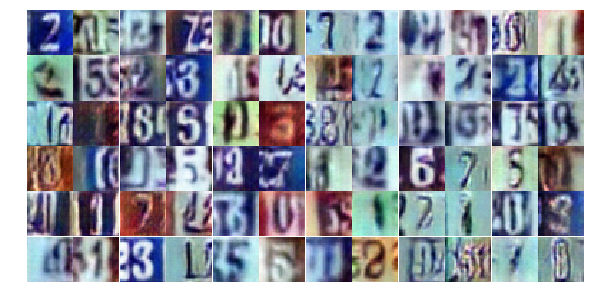

Epoch 13/25... Discriminator Loss: 0.5159... Generator Loss: 1.4343
Epoch 13/25... Discriminator Loss: 1.0622... Generator Loss: 0.5949
Epoch 13/25... Discriminator Loss: 2.7726... Generator Loss: 0.1349
Epoch 13/25... Discriminator Loss: 0.6006... Generator Loss: 1.1534
Epoch 13/25... Discriminator Loss: 0.6128... Generator Loss: 1.1519
Epoch 13/25... Discriminator Loss: 0.8544... Generator Loss: 0.7489
Epoch 13/25... Discriminator Loss: 0.8761... Generator Loss: 0.7894
Epoch 13/25... Discriminator Loss: 0.5509... Generator Loss: 1.2240
Epoch 14/25... Discriminator Loss: 0.8794... Generator Loss: 0.7583
Epoch 14/25... Discriminator Loss: 0.5371... Generator Loss: 1.2165


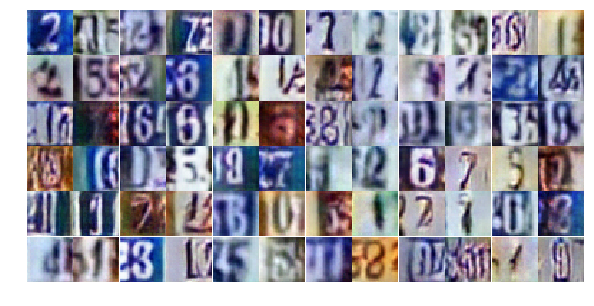

Epoch 14/25... Discriminator Loss: 1.3240... Generator Loss: 0.4457
Epoch 14/25... Discriminator Loss: 1.0701... Generator Loss: 0.6029
Epoch 14/25... Discriminator Loss: 1.0448... Generator Loss: 0.6141
Epoch 14/25... Discriminator Loss: 0.4661... Generator Loss: 1.3402
Epoch 14/25... Discriminator Loss: 0.5446... Generator Loss: 1.2311
Epoch 14/25... Discriminator Loss: 0.8892... Generator Loss: 0.7707
Epoch 14/25... Discriminator Loss: 0.7900... Generator Loss: 0.9086
Epoch 14/25... Discriminator Loss: 1.3221... Generator Loss: 0.4727
Epoch 14/25... Discriminator Loss: 0.7385... Generator Loss: 0.9389
Epoch 14/25... Discriminator Loss: 1.0207... Generator Loss: 0.6308


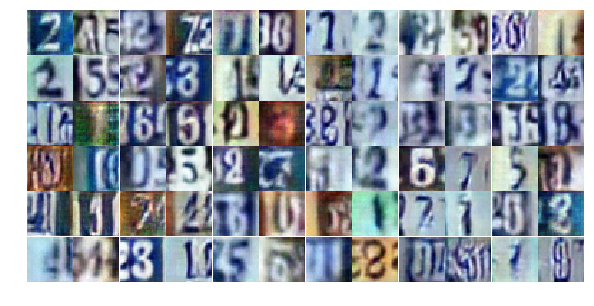

Epoch 15/25... Discriminator Loss: 0.6881... Generator Loss: 1.0906
Epoch 15/25... Discriminator Loss: 0.8609... Generator Loss: 0.8356
Epoch 15/25... Discriminator Loss: 0.8010... Generator Loss: 0.8525
Epoch 15/25... Discriminator Loss: 1.2510... Generator Loss: 0.5024
Epoch 15/25... Discriminator Loss: 0.8690... Generator Loss: 0.8368
Epoch 15/25... Discriminator Loss: 1.3999... Generator Loss: 0.5360
Epoch 15/25... Discriminator Loss: 0.7266... Generator Loss: 0.9280
Epoch 15/25... Discriminator Loss: 0.7673... Generator Loss: 0.8713
Epoch 15/25... Discriminator Loss: 0.6177... Generator Loss: 1.1045
Epoch 15/25... Discriminator Loss: 0.6926... Generator Loss: 1.3930


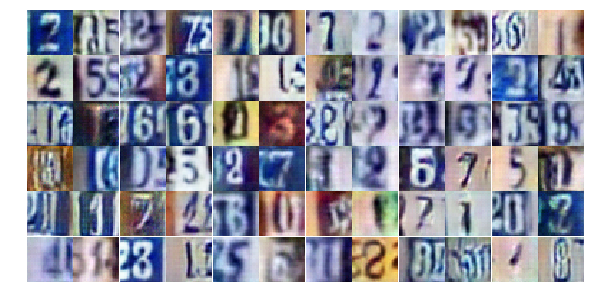

Epoch 15/25... Discriminator Loss: 0.5725... Generator Loss: 1.6778
Epoch 16/25... Discriminator Loss: 1.3314... Generator Loss: 0.4345
Epoch 16/25... Discriminator Loss: 0.5124... Generator Loss: 1.6278
Epoch 16/25... Discriminator Loss: 0.6672... Generator Loss: 1.0315
Epoch 16/25... Discriminator Loss: 1.4520... Generator Loss: 0.5744
Epoch 16/25... Discriminator Loss: 0.5253... Generator Loss: 1.6790
Epoch 16/25... Discriminator Loss: 0.7603... Generator Loss: 0.9285
Epoch 16/25... Discriminator Loss: 1.4223... Generator Loss: 0.4721
Epoch 16/25... Discriminator Loss: 1.0089... Generator Loss: 0.6980
Epoch 16/25... Discriminator Loss: 0.4873... Generator Loss: 1.3060


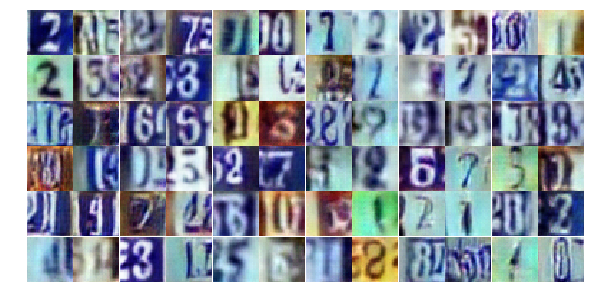

Epoch 16/25... Discriminator Loss: 0.7103... Generator Loss: 1.2529
Epoch 16/25... Discriminator Loss: 1.1648... Generator Loss: 0.5764
Epoch 16/25... Discriminator Loss: 0.6580... Generator Loss: 1.1143
Epoch 17/25... Discriminator Loss: 0.5536... Generator Loss: 1.3039
Epoch 17/25... Discriminator Loss: 1.0371... Generator Loss: 0.6657
Epoch 17/25... Discriminator Loss: 0.7430... Generator Loss: 0.9368
Epoch 17/25... Discriminator Loss: 0.5092... Generator Loss: 1.4383
Epoch 17/25... Discriminator Loss: 0.5928... Generator Loss: 1.1450
Epoch 17/25... Discriminator Loss: 1.3921... Generator Loss: 0.3765
Epoch 17/25... Discriminator Loss: 0.4365... Generator Loss: 1.4217


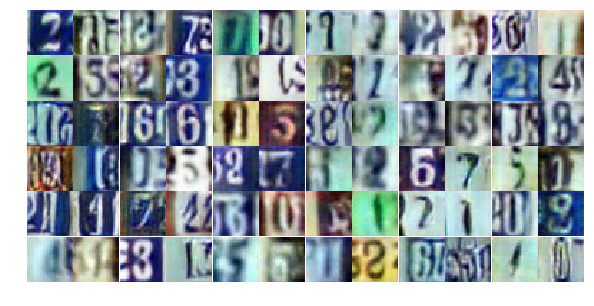

Epoch 17/25... Discriminator Loss: 1.0893... Generator Loss: 0.6196
Epoch 17/25... Discriminator Loss: 0.9460... Generator Loss: 0.6797
Epoch 17/25... Discriminator Loss: 0.7014... Generator Loss: 0.9220
Epoch 17/25... Discriminator Loss: 1.0666... Generator Loss: 0.6413
Epoch 18/25... Discriminator Loss: 0.8778... Generator Loss: 0.8789
Epoch 18/25... Discriminator Loss: 0.5890... Generator Loss: 1.2495
Epoch 18/25... Discriminator Loss: 0.6084... Generator Loss: 1.2500
Epoch 18/25... Discriminator Loss: 0.2415... Generator Loss: 2.0964
Epoch 18/25... Discriminator Loss: 0.7834... Generator Loss: 0.8986
Epoch 18/25... Discriminator Loss: 0.5871... Generator Loss: 1.2494


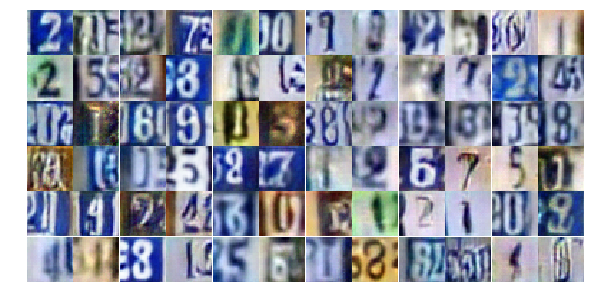

Epoch 18/25... Discriminator Loss: 0.8775... Generator Loss: 0.8435
Epoch 18/25... Discriminator Loss: 0.6987... Generator Loss: 1.0738
Epoch 18/25... Discriminator Loss: 1.0984... Generator Loss: 0.5676
Epoch 18/25... Discriminator Loss: 0.3623... Generator Loss: 1.8246
Epoch 18/25... Discriminator Loss: 0.8138... Generator Loss: 0.7824
Epoch 18/25... Discriminator Loss: 1.2041... Generator Loss: 0.4998
Epoch 19/25... Discriminator Loss: 0.5924... Generator Loss: 1.3263
Epoch 19/25... Discriminator Loss: 0.8538... Generator Loss: 0.8234
Epoch 19/25... Discriminator Loss: 0.8237... Generator Loss: 0.8471
Epoch 19/25... Discriminator Loss: 2.1490... Generator Loss: 0.2275


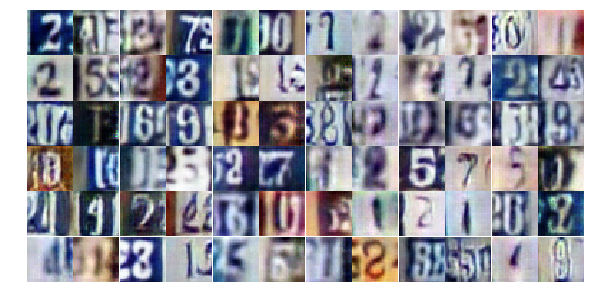

Epoch 19/25... Discriminator Loss: 0.9202... Generator Loss: 0.8029
Epoch 19/25... Discriminator Loss: 1.2133... Generator Loss: 0.5085
Epoch 19/25... Discriminator Loss: 0.6957... Generator Loss: 1.8778
Epoch 19/25... Discriminator Loss: 0.6321... Generator Loss: 1.0570
Epoch 19/25... Discriminator Loss: 1.3227... Generator Loss: 0.4587
Epoch 19/25... Discriminator Loss: 0.6087... Generator Loss: 1.4618
Epoch 19/25... Discriminator Loss: 0.6615... Generator Loss: 0.9993
Epoch 20/25... Discriminator Loss: 0.7730... Generator Loss: 0.9203
Epoch 20/25... Discriminator Loss: 0.5801... Generator Loss: 1.2210
Epoch 20/25... Discriminator Loss: 0.7277... Generator Loss: 0.8743


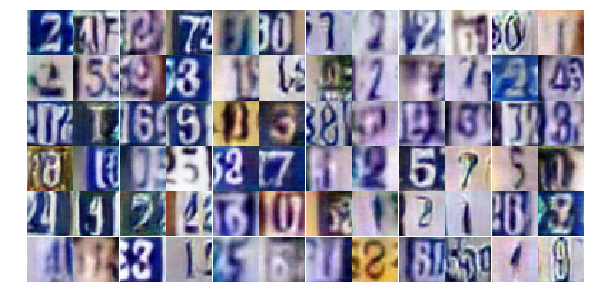

Epoch 20/25... Discriminator Loss: 0.7445... Generator Loss: 0.8669
Epoch 20/25... Discriminator Loss: 1.3306... Generator Loss: 0.4656
Epoch 20/25... Discriminator Loss: 1.4529... Generator Loss: 0.4211
Epoch 20/25... Discriminator Loss: 0.5060... Generator Loss: 1.2704
Epoch 20/25... Discriminator Loss: 1.0893... Generator Loss: 0.7017
Epoch 20/25... Discriminator Loss: 1.1816... Generator Loss: 0.5583
Epoch 20/25... Discriminator Loss: 0.8932... Generator Loss: 0.9103
Epoch 20/25... Discriminator Loss: 0.7005... Generator Loss: 1.0155
Epoch 20/25... Discriminator Loss: 0.8032... Generator Loss: 0.8760
Epoch 21/25... Discriminator Loss: 1.1954... Generator Loss: 0.5045


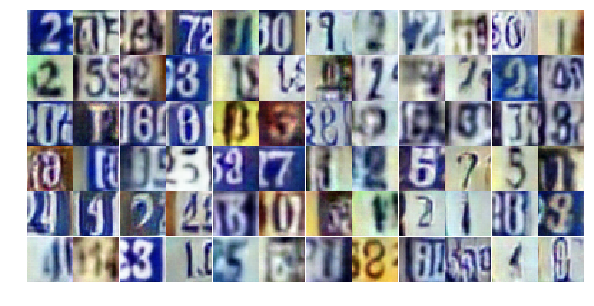

Epoch 21/25... Discriminator Loss: 0.8553... Generator Loss: 0.7781
Epoch 21/25... Discriminator Loss: 1.0329... Generator Loss: 0.6326
Epoch 21/25... Discriminator Loss: 0.6152... Generator Loss: 1.1389
Epoch 21/25... Discriminator Loss: 0.7951... Generator Loss: 0.8003
Epoch 21/25... Discriminator Loss: 0.6598... Generator Loss: 2.2068
Epoch 21/25... Discriminator Loss: 1.6264... Generator Loss: 0.3902
Epoch 21/25... Discriminator Loss: 0.6339... Generator Loss: 1.0641
Epoch 21/25... Discriminator Loss: 0.1759... Generator Loss: 2.6224
Epoch 21/25... Discriminator Loss: 0.5219... Generator Loss: 1.3453
Epoch 21/25... Discriminator Loss: 0.6238... Generator Loss: 1.2634


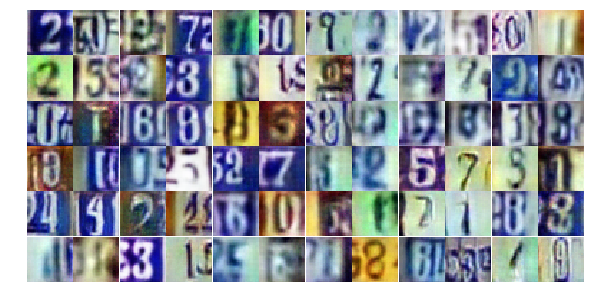

Epoch 22/25... Discriminator Loss: 0.8795... Generator Loss: 0.7874
Epoch 22/25... Discriminator Loss: 1.0986... Generator Loss: 0.5746
Epoch 22/25... Discriminator Loss: 1.0991... Generator Loss: 0.5632
Epoch 22/25... Discriminator Loss: 1.8851... Generator Loss: 0.2920
Epoch 22/25... Discriminator Loss: 0.4986... Generator Loss: 1.3415
Epoch 22/25... Discriminator Loss: 1.0476... Generator Loss: 0.6283
Epoch 22/25... Discriminator Loss: 0.7591... Generator Loss: 0.9040
Epoch 22/25... Discriminator Loss: 0.7424... Generator Loss: 1.0125
Epoch 22/25... Discriminator Loss: 0.5692... Generator Loss: 1.1580
Epoch 22/25... Discriminator Loss: 0.5515... Generator Loss: 1.3330


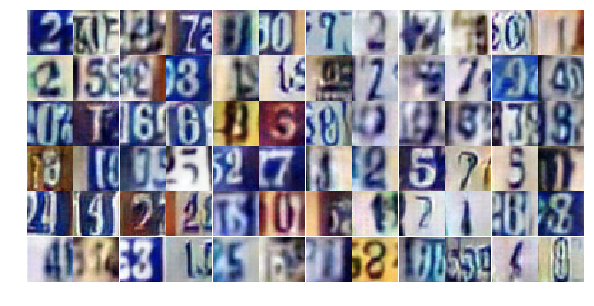

Epoch 22/25... Discriminator Loss: 0.5682... Generator Loss: 1.2914
Epoch 22/25... Discriminator Loss: 0.9934... Generator Loss: 0.7603
Epoch 23/25... Discriminator Loss: 0.8206... Generator Loss: 0.8002
Epoch 23/25... Discriminator Loss: 0.4673... Generator Loss: 1.4911
Epoch 23/25... Discriminator Loss: 0.4443... Generator Loss: 1.4499
Epoch 23/25... Discriminator Loss: 0.6932... Generator Loss: 1.6654
Epoch 23/25... Discriminator Loss: 0.5610... Generator Loss: 1.7683
Epoch 23/25... Discriminator Loss: 0.9121... Generator Loss: 1.7023
Epoch 23/25... Discriminator Loss: 0.6852... Generator Loss: 1.1272
Epoch 23/25... Discriminator Loss: 0.5763... Generator Loss: 1.3134


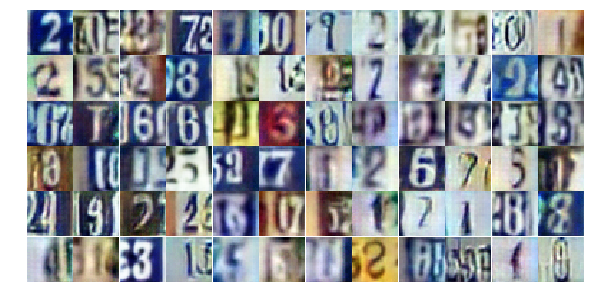

Epoch 23/25... Discriminator Loss: 1.7523... Generator Loss: 3.0780
Epoch 23/25... Discriminator Loss: 0.6989... Generator Loss: 1.1040
Epoch 23/25... Discriminator Loss: 1.7558... Generator Loss: 0.3274
Epoch 24/25... Discriminator Loss: 0.7073... Generator Loss: 1.3959
Epoch 24/25... Discriminator Loss: 0.8152... Generator Loss: 0.9751
Epoch 24/25... Discriminator Loss: 0.4777... Generator Loss: 1.3767
Epoch 24/25... Discriminator Loss: 0.6883... Generator Loss: 3.4638
Epoch 24/25... Discriminator Loss: 0.5745... Generator Loss: 1.2592
Epoch 24/25... Discriminator Loss: 0.5874... Generator Loss: 1.1862
Epoch 24/25... Discriminator Loss: 0.7161... Generator Loss: 1.5176


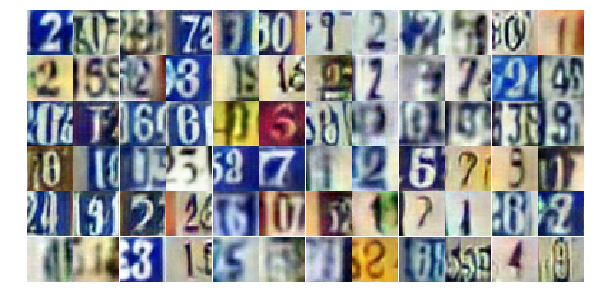

Epoch 24/25... Discriminator Loss: 1.2259... Generator Loss: 0.5163
Epoch 24/25... Discriminator Loss: 0.5754... Generator Loss: 1.3684
Epoch 24/25... Discriminator Loss: 0.8985... Generator Loss: 0.7482
Epoch 24/25... Discriminator Loss: 0.9060... Generator Loss: 0.9581
Epoch 24/25... Discriminator Loss: 1.4741... Generator Loss: 0.3988
Epoch 25/25... Discriminator Loss: 1.7096... Generator Loss: 0.3300
Epoch 25/25... Discriminator Loss: 1.1616... Generator Loss: 2.4090
Epoch 25/25... Discriminator Loss: 0.7751... Generator Loss: 0.9048
Epoch 25/25... Discriminator Loss: 0.9430... Generator Loss: 0.7307
Epoch 25/25... Discriminator Loss: 0.5266... Generator Loss: 1.3751


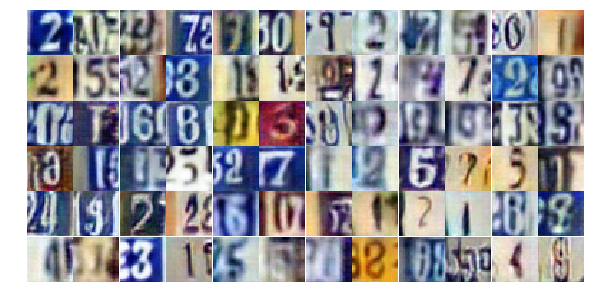

Epoch 25/25... Discriminator Loss: 1.5471... Generator Loss: 0.3728
Epoch 25/25... Discriminator Loss: 0.3644... Generator Loss: 1.6266
Epoch 25/25... Discriminator Loss: 1.3969... Generator Loss: 0.4732
Epoch 25/25... Discriminator Loss: 1.5790... Generator Loss: 0.6018
Epoch 25/25... Discriminator Loss: 0.9452... Generator Loss: 0.8005
Epoch 25/25... Discriminator Loss: 0.6875... Generator Loss: 1.0111


In [20]:
# Load the data and train the network here
epochs = 25
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, print_every=50, show_every=500, figsize=(10,5))

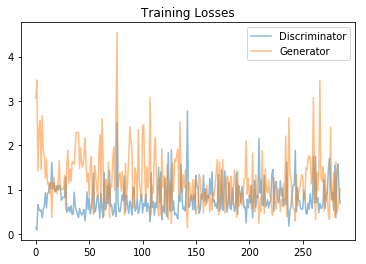

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

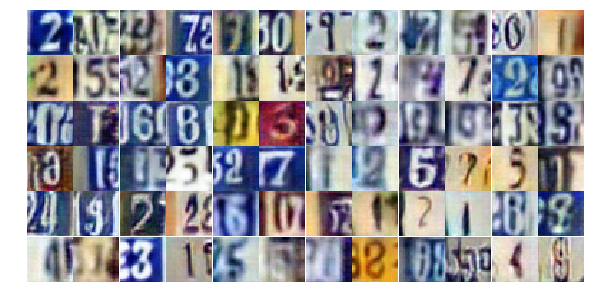

In [22]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))